### Multi Objective Optimization with Credit Risk Analysis
Here we will optimize our AI model for multiple objectives - Performance with Area Under Curve (AUC), and Fairness with Statistical Disparity (SD)

In [179]:
%%capture
#Cell magic to hide outputs 
#For Synthetic Data Generation
!pip install sdv
from sdv.tabular import GaussianCopula

from io import StringIO
import os
import time
import sys
import IPython
from time import gmtime, strftime

import boto3
import numpy as np
import pandas as pd
import urllib

import sagemaker
from sagemaker.s3 import S3Uploader
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
from sagemaker.s3 import S3Downloader
from sagemaker.s3 import S3Uploader
from sagemaker import Session
from sagemaker import get_execution_role
from sagemaker.xgboost import XGBoostModel
from sagemaker.sklearn import SKLearnModel
from sagemaker.pipeline import PipelineModel
from sagemaker.inputs import TrainingInput


session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/sagemaker-amt-credit-risk-model"
region = session.boto_region_name

# Define IAM role
role = get_execution_role()

In [180]:
#Retrieve Biased dataset from "2-DataCreation.ipynb" Notebook 
%store -r BiasedData1

In [181]:
training_data = BiasedData1 
training_data.info()
BiasedData1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   status                   2000 non-null   int64  
 1   duration                 2000 non-null   int64  
 2   credit_history           2000 non-null   int64  
 3   purpose                  2000 non-null   int64  
 4   amount                   2000 non-null   float64
 5   savings                  2000 non-null   int64  
 6   employment_duration      2000 non-null   int64  
 7   installment_rate         2000 non-null   int64  
 8   personal_status_sex      2000 non-null   int64  
 9   other_debtors            2000 non-null   int64  
 10  present_residence        2000 non-null   int64  
 11  property                 2000 non-null   int64  
 12  age                      2000 non-null   int64  
 13  other_installment_plans  2000 non-null   int64  
 14  housing                  

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,present_residence,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049.0,1,2,4,2,1,4,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799.0,1,3,2,3,1,2,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841.0,2,4,2,2,1,4,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122.0,1,3,3,3,1,2,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171.0,1,3,4,3,1,4,2,38,1,2,2,2,2,1,1,1


### Create the raw training and test CSV files

In [182]:
# prepare raw test data
test_data = training_data.sample(frac=0.1)
test_data = test_data.drop(["credit_risk"], axis=1)
test_filename = "test.csv"
test_columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
]
test_data.to_csv(test_filename, index=False, header=True, columns=test_columns, sep=",")

# prepare raw training data
credit_columns = [
    "status",
    "duration",
    "credit_history",
    "purpose",
    "amount",
    "savings",
    "employment_duration",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "number_credits",
    "job",
    "people_liable",
    "telephone",
    "foreign_worker",
    "credit_risk",
]
train_filename = "train.csv"
training_data.to_csv(train_filename, index=False, header=True, columns=credit_columns, sep=",")

### Encode and Upload Data
Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for XGBoost models.

In [183]:
test_raw = S3Uploader.upload(test_filename, "s3://{}/{}/data/test".format(bucket, prefix))
(test_raw)

's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/test/test.csv'

In [184]:
train_raw = S3Uploader.upload(train_filename, "s3://{}/{}/data/train".format(bucket, prefix))
print(train_raw)

s3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/train/train.csv


### Preprocessing and feature engineering with SageMaker Processing job

We will use SageMaker Processing jobs to perform the preprocessing on the raw data. SageMaker Processing provides prebuilt container for SKlearn which we will use here. We will output a sklearn model that can be used for preprocessing inference requests. 

In [185]:
sklearn_processor = SKLearnProcessor(
    role=role,
    base_job_name="sagemaker-amt-credit-risk-processing-job",
    instance_type="ml.m5.large",
    instance_count=1,
    framework_version="0.20.0",
)

You can have a look at the preprocessing script prepared to run in the processing job

In [186]:
# !pygmentize processing/preprocessor.py

#### NOTE: THIS CELL WILL RUN FOR APPROX. 5-8 MINUTES! PLEASE BE PATIENT. 
For further documentation on SageMaker Processing, you can refer the documentation [here](https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job.html)

In [187]:
raw_data_path = "s3://{0}/{1}/data/train/".format(bucket, prefix)
train_data_path = "s3://{0}/{1}/data/preprocessed/train/".format(bucket, prefix)
val_data_path = "s3://{0}/{1}/data/preprocessed/val/".format(bucket, prefix)
model_path = "s3://{0}/{1}/sklearn/".format(bucket, prefix)


sklearn_processor.run(
    code="processing/preprocessor.py",
    inputs=[
        ProcessingInput(
            input_name="raw_data", source=raw_data_path, destination="/opt/ml/processing/input"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train_data", source="/opt/ml/processing/train", destination=train_data_path
        ),
        ProcessingOutput(
            output_name="val_data", source="/opt/ml/processing/val", destination=val_data_path
        ),
        ProcessingOutput(
            output_name="model", source="/opt/ml/processing/model", destination=model_path
        ),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
    logs=False,
)


Job Name:  sagemaker-amt-credit-risk-processing-jo-2022-11-25-15-49-58-994
Inputs:  [{'InputName': 'raw_data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/train/', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-921553072635/sagemaker-amt-credit-risk-processing-jo-2022-11-25-15-49-58-994/input/code/preprocessor.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/preprocessed/train/', 'LocalPath': '/opt/ml/proce

KeyboardInterrupt: 

## Train XGBoost Model
In this step, we will train an XGBoost model on the preprocessed data. We will use our own training script with the built-in XGBoost container provided by SageMaker.

Alternatively, for your own use case, you can also bring your own model (trained elsewhere) to SageMaker for processing with SageMaker Clarify


### Set up XGBoost Estimator

Next, let us set up:    
 1. Pre-defined values for Hyperparameters for XGBoost algorithm
 1. XGBoost Estimator for SageMaker

    

In [188]:
hyperparameters = {
    "max_depth": "5",
    "eta": "0.1",
    "gamma": "4",
    "min_child_weight": "6",
    "silent": "1",
    "objective": "binary:logistic",
    "num_round": "100",
    "subsample": "0.8",
    "eval_metric": "auc",
    "early_stopping_rounds": "20",
    "output_data_dir": "/opt/ml/output/data/",
}

entry_point = "train_xg_amt.py"
source_dir = "training/"
output_path = "s3://{0}/{1}/{2}".format(bucket, prefix, "xgb_model")
code_location = "s3://{0}/{1}/code".format(bucket, prefix)

estimator = XGBoost(
    entry_point=entry_point,
    source_dir=source_dir,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    instance_type="ml.c5.xlarge",
    instance_count=1,
    framework_version="0.90-2",
    py_version="py3",
    role=role,
)

### SageMaker AMT (HPO)

Now it's time to run the HPO job to train and find the best model 

#### NOTE: THIS CELL WILL RUN FOR APPROX. 5-8 MINUTES! PLEASE BE PATIENT.

In [ ]:
# Automatic Model Tuning (HPO)

# output_data_dir = 's3://sagemaker-us-east-2-921553072635/sagemaker/sagemaker-amt-credit-risk-model/data/output/'

from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': IntegerParameter(1, 10),
                        'gamma': IntegerParameter(1, 5),
                        'max_depth': IntegerParameter(1, 10)}

objective_metric_name = 'validation:auc'

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=500, # 500
                            max_parallel_jobs=10, #16
                           )

tuning_job_name = "xgb-tuner-{}".format(strftime("%d-%H-%M-%S", gmtime()))

# inputs = {'train': train_data_path, 'validation': val_data_path, 'output_data_dir': output_data_dir}

inputs = {'train': train_data_path, 'validation': val_data_path}

tuner.fit(inputs, job_name=tuning_job_name)

tuner.wait()

tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!
!


In [191]:
# Generate Pareto Frontier 
def get_pareto_frontier(Xs, Ys, maxX=False, maxY=True):
    """plot Pareto front

    in AMT this is impossible, since there is only one merged metric, But I
    show here just from a scientific viewpoint

    """
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    return pf_X, pf_Y

In [192]:
import boto3
import pandas as pd
import io

s3 = boto3.resource('s3')
bucket = s3.Bucket('sagemaker-us-east-2-921553072635')
prefix_objs = bucket.objects.filter(Prefix="sagemaker/sagemaker-amt-credit-risk-model/data/output/v4/")
objects = iter(prefix_objs)
next(objects)

s3.ObjectSummary(bucket_name='sagemaker-us-east-2-921553072635', key='sagemaker/sagemaker-amt-credit-risk-model/data/output/v4/')

In [193]:
prefix_df = []

from io import BytesIO

for obj in objects:
    key = obj.key
    body = obj.get()['Body'].read()
    tmp = str(body, 'UTF-8').strip()
    prefix_df.append(tmp)
    
# prefix_df

In [265]:
df = pd.DataFrame(prefix_df)
df['models_list'] = df[0].str.split(',')
df_models = pd.DataFrame(df['models_list'].tolist()).fillna('').add_prefix('model_')
df_models.rename(columns={'model_0': 'sd', 'model_1': 'auc'}, inplace=True)
df_models.to_csv('sd_auc_pareto_frontier.csv', index=False, header=True)
sd_str_list = df_models.iloc[:, 0].tolist()
sd_float_list = [float(x) for x in sd_str_list]
auc_str_list = df_models.iloc[:, -1].tolist()
auc_float_list = [float(x) for x in auc_str_list]

In [272]:
pf_X, pf_Y = get_pareto_frontier(Xs=sd_float_list,Ys=auc_float_list)

Baseline Statistical Disparity:  0.4
Baseline Area Under Curve:  0.91 

Optimized Statistical Disparity:  0.28
Optimized Area Under Curve:  0.89 



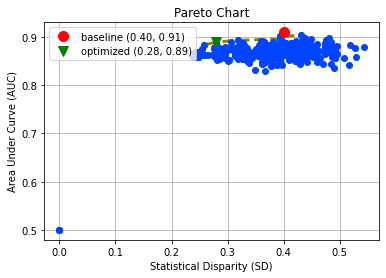

In [273]:
%matplotlib inline
from matplotlib import pyplot as plt

#Worst one wihtout optimization
baseline_sd = 0.40 
baseline_auc = 0.91

#After optimization
optimized_sd = 0.28 
optimized_auc = 0.89

ax = plt.subplots()
#Add grid 
plt.grid()

#Graph pareto front chart 
plt.title("Pareto Chart")
plt.xlabel("Statistical Disparity (SD)")
plt.ylabel("Area Under Curve (AUC)")

#Plot co ordinates 
plt.plot(pf_X[6:], pf_Y[6:], linestyle='--', linewidth=3, marker='o', c='#8B8000', mfc='b')
#Plot additional points
plt.plot(sd_float_list, auc_float_list, linestyle='None', marker='o', color='#0044FF')
#Show baseline SD & AUC - MAKE LARGER
plt.plot(baseline_sd, baseline_auc, "ro", markersize='10', label="baseline (0.40, 0.91)")
#Show optimized SD & AUC - MAKE LARGER
plt.plot(optimized_sd, optimized_auc, "gv", markersize='10', label="optimized (0.28, 0.89)")
#Legend
plt.legend(loc="upper left")

#Print Baseline Values 
print("Baseline Statistical Disparity: ",baseline_sd)
print("Baseline Area Under Curve: ",baseline_auc,"\n")

#Print Optimized Values
print("Optimized Statistical Disparity: ",optimized_sd)
print("Optimized Area Under Curve: ",optimized_auc,"\n")

### The cell below provides a range of visualization for the tuning job above. This visualization and its libraries were provided by the following repo:

https://github.com/aws-samples/amazon-sagemaker-amt-visualize/blob/main/1_tuning_of_builtin_xgboost.ipynb 

In [261]:
#!pip install altair
from amtviz import visualize_tuning_job
visualize_tuning_job(tuner, trials_only=True)

Tuning job xgb-tuner-25-15-50-49     status: Completed

Number of training jobs with valid objective: 500
Lowest: 0.6000000238418579 Highest 0.8558380007743835


,eta,gamma,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,validation:auc
233,0.361160,5.0,10.0,1.0,xgb-tuner-25-15-50-49-267-9d337804,Completed,2022-11-25 16:17:38+00:00,2022-11-25 16:18:09+00:00,31.0,xgb-tuner-25-15-50-49,0.855838
93,0.857224,1.0,10.0,6.0,xgb-tuner-25-15-50-49-407-c98be4c6,Completed,2022-11-25 16:31:20+00:00,2022-11-25 16:31:52+00:00,32.0,xgb-tuner-25-15-50-49,0.855053
446,0.425336,5.0,10.0,4.0,xgb-tuner-25-15-50-49-054-1138efe5,Completed,2022-11-25 15:57:17+00:00,2022-11-25 15:57:49+00:00,32.0,xgb-tuner-25-15-50-49,0.850655
462,0.539866,5.0,10.0,1.0,xgb-tuner-25-15-50-49-038-92988607,Completed,2022-11-25 15:55:48+00:00,2022-11-25 15:56:20+00:00,32.0,xgb-tuner-25-15-50-49,0.849658
425,0.280832,5.0,4.0,7.0,xgb-tuner-25-15-50-49-075-8c466d85,Completed,2022-11-25 15:59:14+00:00,2022-11-25 15:59:46+00:00,32.0,xgb-tuner-25-15-50-49,0.848113
216,0.362250,5.0,6.0,8.0,xgb-tuner-25-15-50-49-284-38e08ea1,Completed,2022-11-25 16:19:23+00:00,2022-11-25 16:19:55+00:00,32.0,xgb-tuner-25-15-50-49,0.846070
198,0.362379,5.0,6.0,8.0,xgb-tuner-25-15-50-49-302-cce548b0,Completed,2022-11-25 16:21:10+00:00,2022-11-25 16:21:42+00:00,32.0,xgb-tuner-25-15-50-49,0.846070
343,0.250395,5.0,6.0,4.0,xgb-tuner-25-15-50-49-157-3eb1358a,Completed,2022-11-25 16:06:22+00:00,2022-11-25 16:06:54+00:00,32.0,xgb-tuner-25-15-50-49,0.844974
151,0.785107,1.0,10.0,1.0,xgb-tuner-25-15-50-49-349-d764026b,Completed,2022-11-25 16:25:36+00:00,2022-11-25 16:26:07+00:00,31.0,xgb-tuner-25-15-50-49,0.844762
137,0.841344,5.0,10.0,4.0,xgb-tuner-25-15-50-49-363-7b8558eb,Completed,2022-11-25 16:26:54+00:00,2022-11-25 16:27:21+00:00,27.0,xgb-tuner-25-15-50-49,0.844475


alt.VConcatChart(...)